# Reinforcement Learning - Deep Q Network

In [1]:
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1) 

%matplotlib inline
import matplotlib.pyplot as plt
import sys
import time
import gym

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [2]:
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128, observation_space=4, action_space=2):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(observation_space, num_hidden)
        self.l2 = nn.Linear(num_hidden, action_space)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.l2(self.relu(self.l1(x)))

        return out

In [3]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        return batch

    def __len__(self):
        return len(self.memory)

In [4]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        if random.random() < self.epsilon:
            action = random.randint(0, 1)
        else:
            with torch.no_grad():
                action = torch.argmax(self.Q(torch.Tensor(obs))).item()
        return int(action)
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

In [5]:
def get_epsilon(it, start=1, end=0.05, length=1000):
    if it < length:
        epsilon =  - it/(1000/0.95)
    else:
        epsilon = 0.05
    return epsilon

def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def compute_q_vals(Q, states, actions):
    """
    This method returns Q values for given state action pairs.
    
    Args:
        Q: Q-net
        states: a tensor of states. Shape: batch_size x obs_dim
        actions: a tensor of actions. Shape: Shape: batch_size x 1

    Returns:
        A torch tensor filled with Q values. Shape: batch_size x 1.
    """
    QValues = Q(states)[torch.arange(len(actions)), actions.squeeze()]
    return QValues.unsqueeze(dim=1)

def compute_targets(Q, rewards, next_states, dones, discount_factor):
    """
    This method returns targets (values towards which Q-values should move).
    
    Args:
        Q: Q-net
        rewards: a tensor of actions. Shape: Shape: batch_size x 1
        next_states: a tensor of states. Shape: batch_size x obs_dim
        dones: a tensor of boolean done flags (indicates if next_state is terminal) Shape: batch_size x 1
        discount_factor: discount
    Returns:
        A torch tensor filled with target values. Shape: batch_size x 1.
    """
    maxQs = torch.max(Q(next_states), 1).values
    if isinstance(dones, torch.BoolTensor):
        targets = rewards + discount_factor * maxQs.unsqueeze(dim=1) * (~dones)
    else:
        targets = rewards + discount_factor * maxQs.unsqueeze(dim=1) * (1 - dones)
    return targets
    
def train(Q, memory, optimizer, batch_size, discount_factor):
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)[:, None]  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)[:, None]
    done = torch.tensor(done, dtype=torch.uint8)[:, None]  # Boolean
    
    # compute the q value
    q_val = compute_q_vals(Q, state, action)
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [6]:

def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate, rendering_criterium=999999):
    
    optimizer = optim.Adam(Q.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_scores = []  #
    rendering = False
    for i in range(num_episodes):
        state = env.reset()
        
        score = 0
        while True:
            # YOUR CODE HERE
            policy.set_epsilon(get_epsilon(global_steps))
            action = policy.sample_action(state)
            state_next, reward, done, _ = env.step(action)                

            loss = train(Q, memory, optimizer, batch_size, discount_factor)

            global_steps += 1
            score += reward

            if rendering:
                env.render()
                time.sleep(0.05)

            memory.push((state, action, reward, state_next, done))
            state = state_next

            if done:
                if i % 10 == 0:
                    print("{2} Episode {0} finished with a score of {1}"
                          .format(i, score, '\033[99m'))
                episode_scores.append(score)

                if score > rendering_criterium:
                    input("rendering")
                    rendering = True
                else:
                    rendering = False
                break
            
        env.close()
    return episode_scores

In [7]:
####### OpenAI Gym Discrete Action Classic Control Envs ########

# new_env = gym.envs.make("MountainCar-v0")
# rendering_criterium = -200

# new_env = gym.envs.make("CartPole-v1")
# rendering_criterium = 200

new_env = gym.envs.make("Acrobot-v1")
rendering_criterium = -200

# no rendering
rendering_criterium = 999999

WARN: gym.spaces.Box autodetected dtype as &lt;class &#39;numpy.float32&#39;&gt;. Please provide explicit dtype.


 Episode 0 finished with a score of -500.0
 Episode 10 finished with a score of -500.0
 Episode 20 finished with a score of -225.0
 Episode 30 finished with a score of -500.0
 Episode 40 finished with a score of -500.0
 Episode 50 finished with a score of -326.0
 Episode 60 finished with a score of -319.0
 Episode 70 finished with a score of -393.0
 Episode 80 finished with a score of -500.0
 Episode 90 finished with a score of -450.0


Text(0.5, 1.0, &#39;Episode durations per episode&#39;)

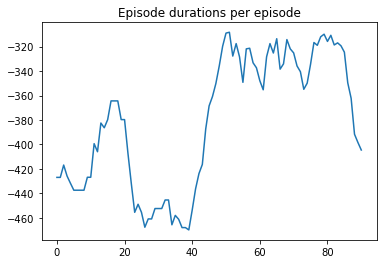

In [8]:
# Let's run it!
num_episodes = 100
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
new_env.seed(seed)

Q_net = QNetwork(num_hidden, observation_space=new_env.observation_space.low.shape[0], action_space=new_env.action_space.n)
policy = EpsilonGreedyPolicy(Q_net, 0.05)
episode_durations = run_episodes(train, Q_net, policy, memory, new_env, num_episodes, batch_size, discount_factor, learn_rate, rendering_criterium=rendering_criterium)

plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')